In [140]:
import numpy as np

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from validation import TimeSeriesWalkingForwardCV, TimeSeriesWindowCV
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (40, 20)

In [141]:
%store -r features_scaled
%store -r data_cp
%store -r Y

In [142]:
features = features_scaled[24*60:-24*30]
targets = Y[24*60:-24*30]

In [143]:
def MAE(x, y):
    return (np.abs(x - y)).mean(axis=0)

def RelativeAE(x, y):
    return (np.abs(x - y)).sum(axis=0) / np.abs(y).sum(axis=0)

<ipython-input-144-4a2a4a2a94bb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates)


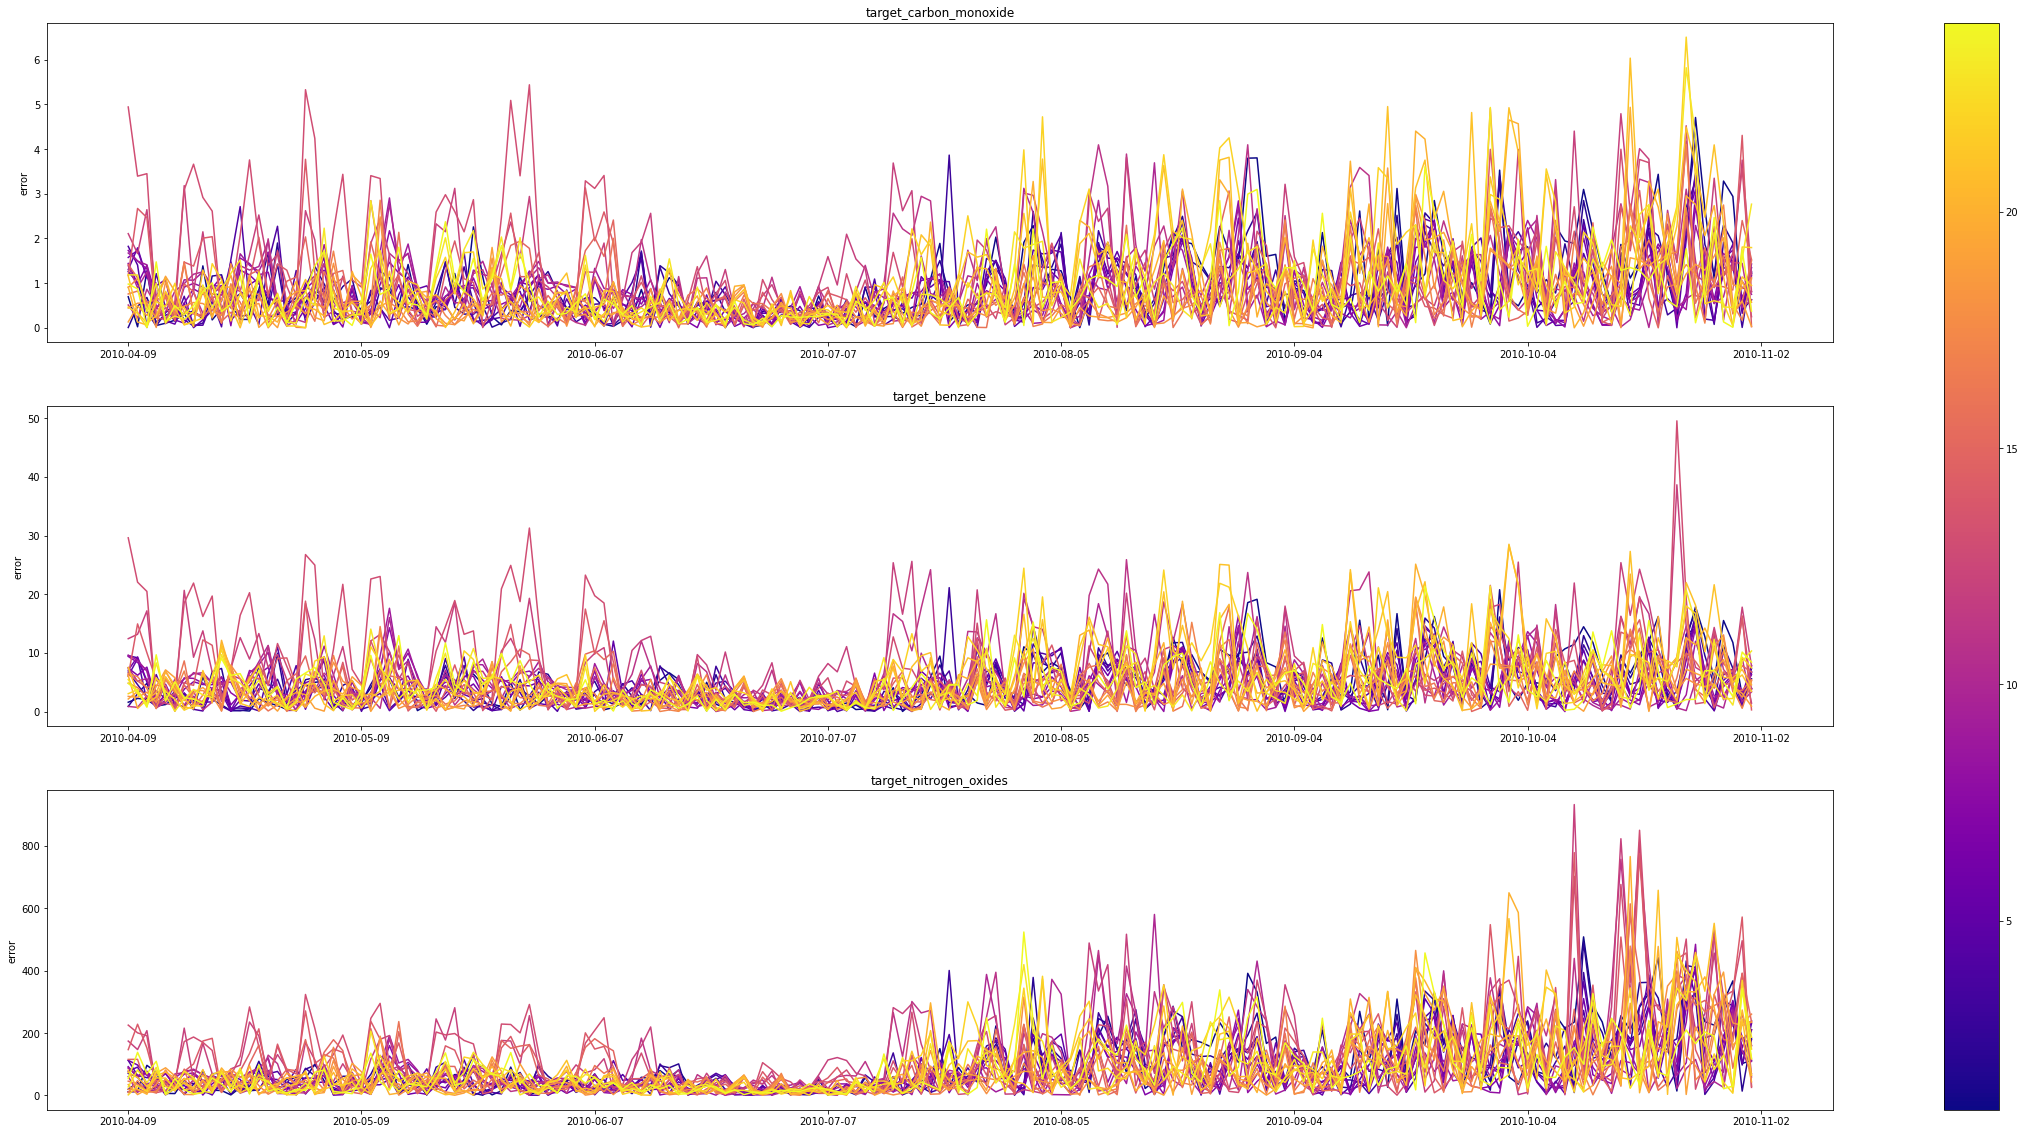

In [144]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWindowCV(Ridge, 24*30, 24, 24, fig, axs, param_grid={'alpha': [2], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)
# optimizer_lasso = TimeSeriesWindowCV(Lasso, 24*30, 24*10, 24, fig, axs, param_grid={'alpha': [0.1], 'tol':[1e-4, 1e-3], 'max_iter': [1000000]})
# optimizer_lasso.fit(features_scaled, np.array(Y), RelativeAE)


for ax in axs:
    dates = list(data_cp.date_time.dt.date[::len(data_cp) // len(ax.get_xticklabels())].astype('string'))
    ax.set_xticklabels(dates)

<ipython-input-15-dfa1deb7c42d>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates)


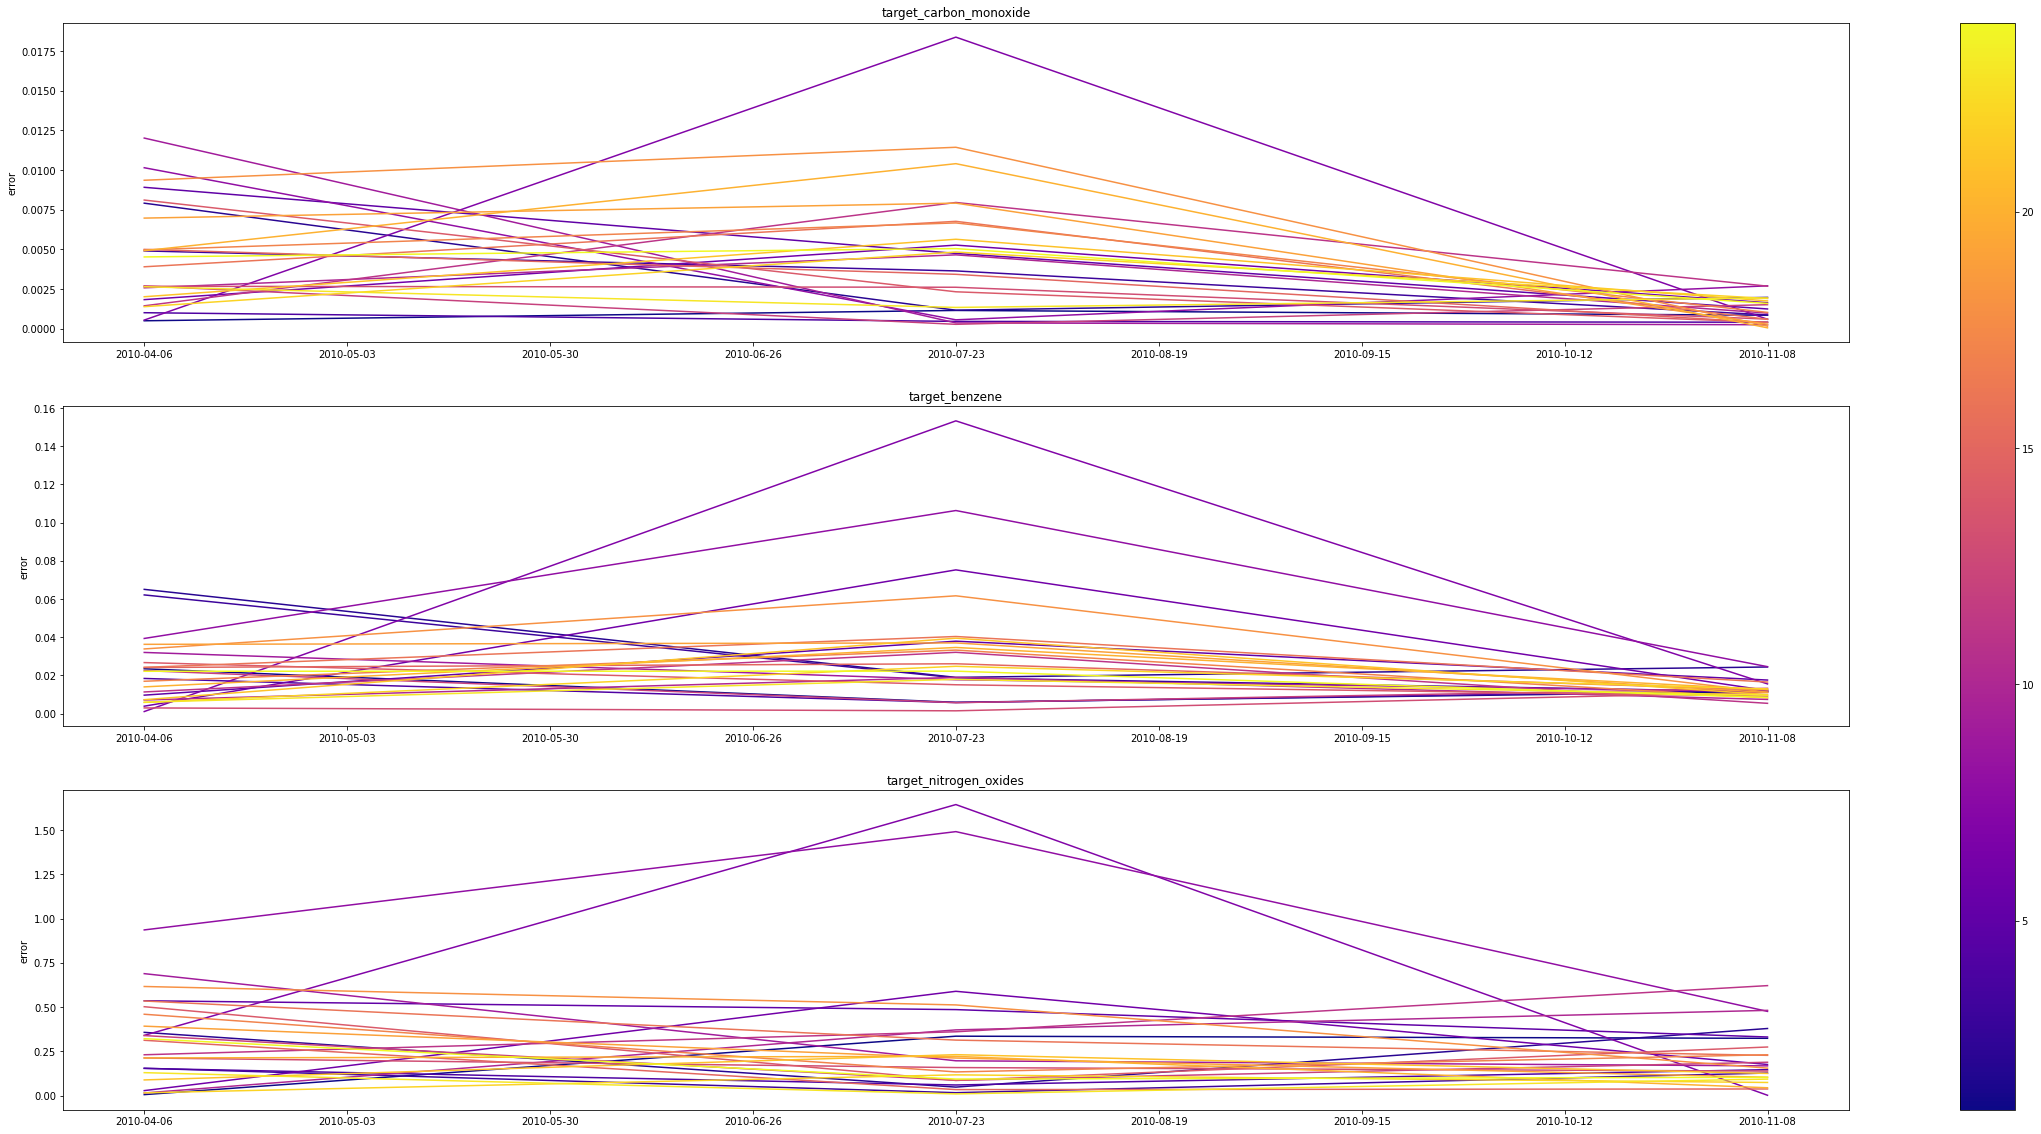

In [15]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWindowCV(RandomForestRegressor, 24*30, 24, 3000, fig, axs, param_grid={'max_depth': [200], 'min_samples_leaf': [5], 'n_estimators': [100]})
optimizer_forest.fit(features_scaled, np.array(Y), RelativeAE)

for ax in axs:
    dates = list(data_cp.date_time.dt.date[::len(data_cp) // len(ax.get_xticklabels())].astype('string'))
    ax.set_xticklabels(dates)

<ipython-input-8-aa47c2b3e618>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates)


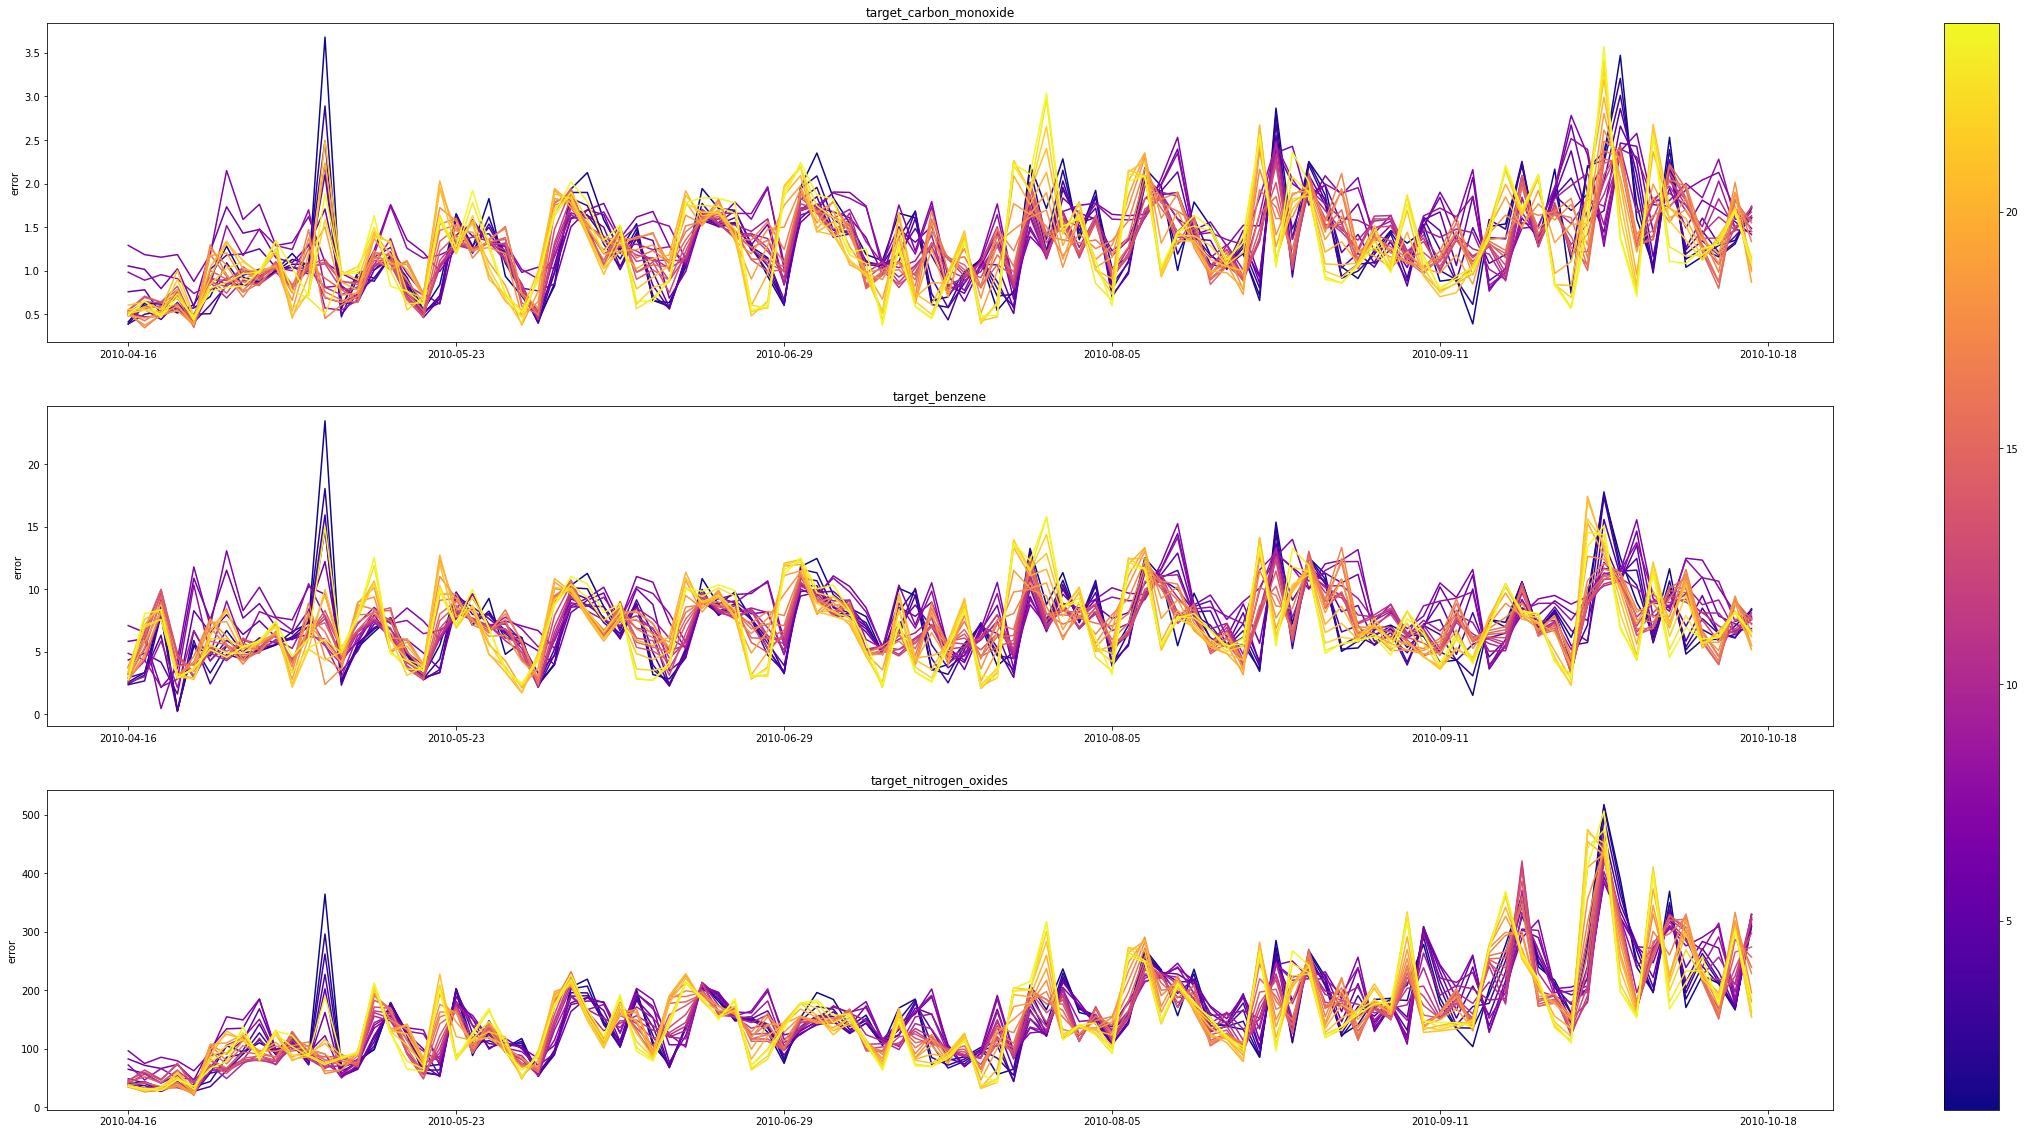

In [8]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')

optimizer_ridge = TimeSeriesWalkingForwardCV(Ridge, test_size=24, n_splits=100, fig=fig, axs=axs, param_grid={'alpha': [0.05], 'tol':[1e-4]})
optimizer_ridge.fit(features, np.array(targets), MAE)
# optimizer_lasso = TimeSeriesWalkingForwardCV(Lasso, test_size=24*10, n_splits=20, fig=fig, axs=axs, param_grid={'alpha': [0.05, 0.1, 0.5, 1], 'tol':[1e-4], 'max_iter': [1000000]})
# optimizer_lasso.fit(features_scaled, np.array(Y), MAE)

for ax in axs:
    dates = list(data_cp.date_time.dt.date[::len(data_cp) // len(ax.get_xticklabels())].astype('string'))
    ax.set_xticklabels(dates)

<ipython-input-17-a93f2b7acf13>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates)


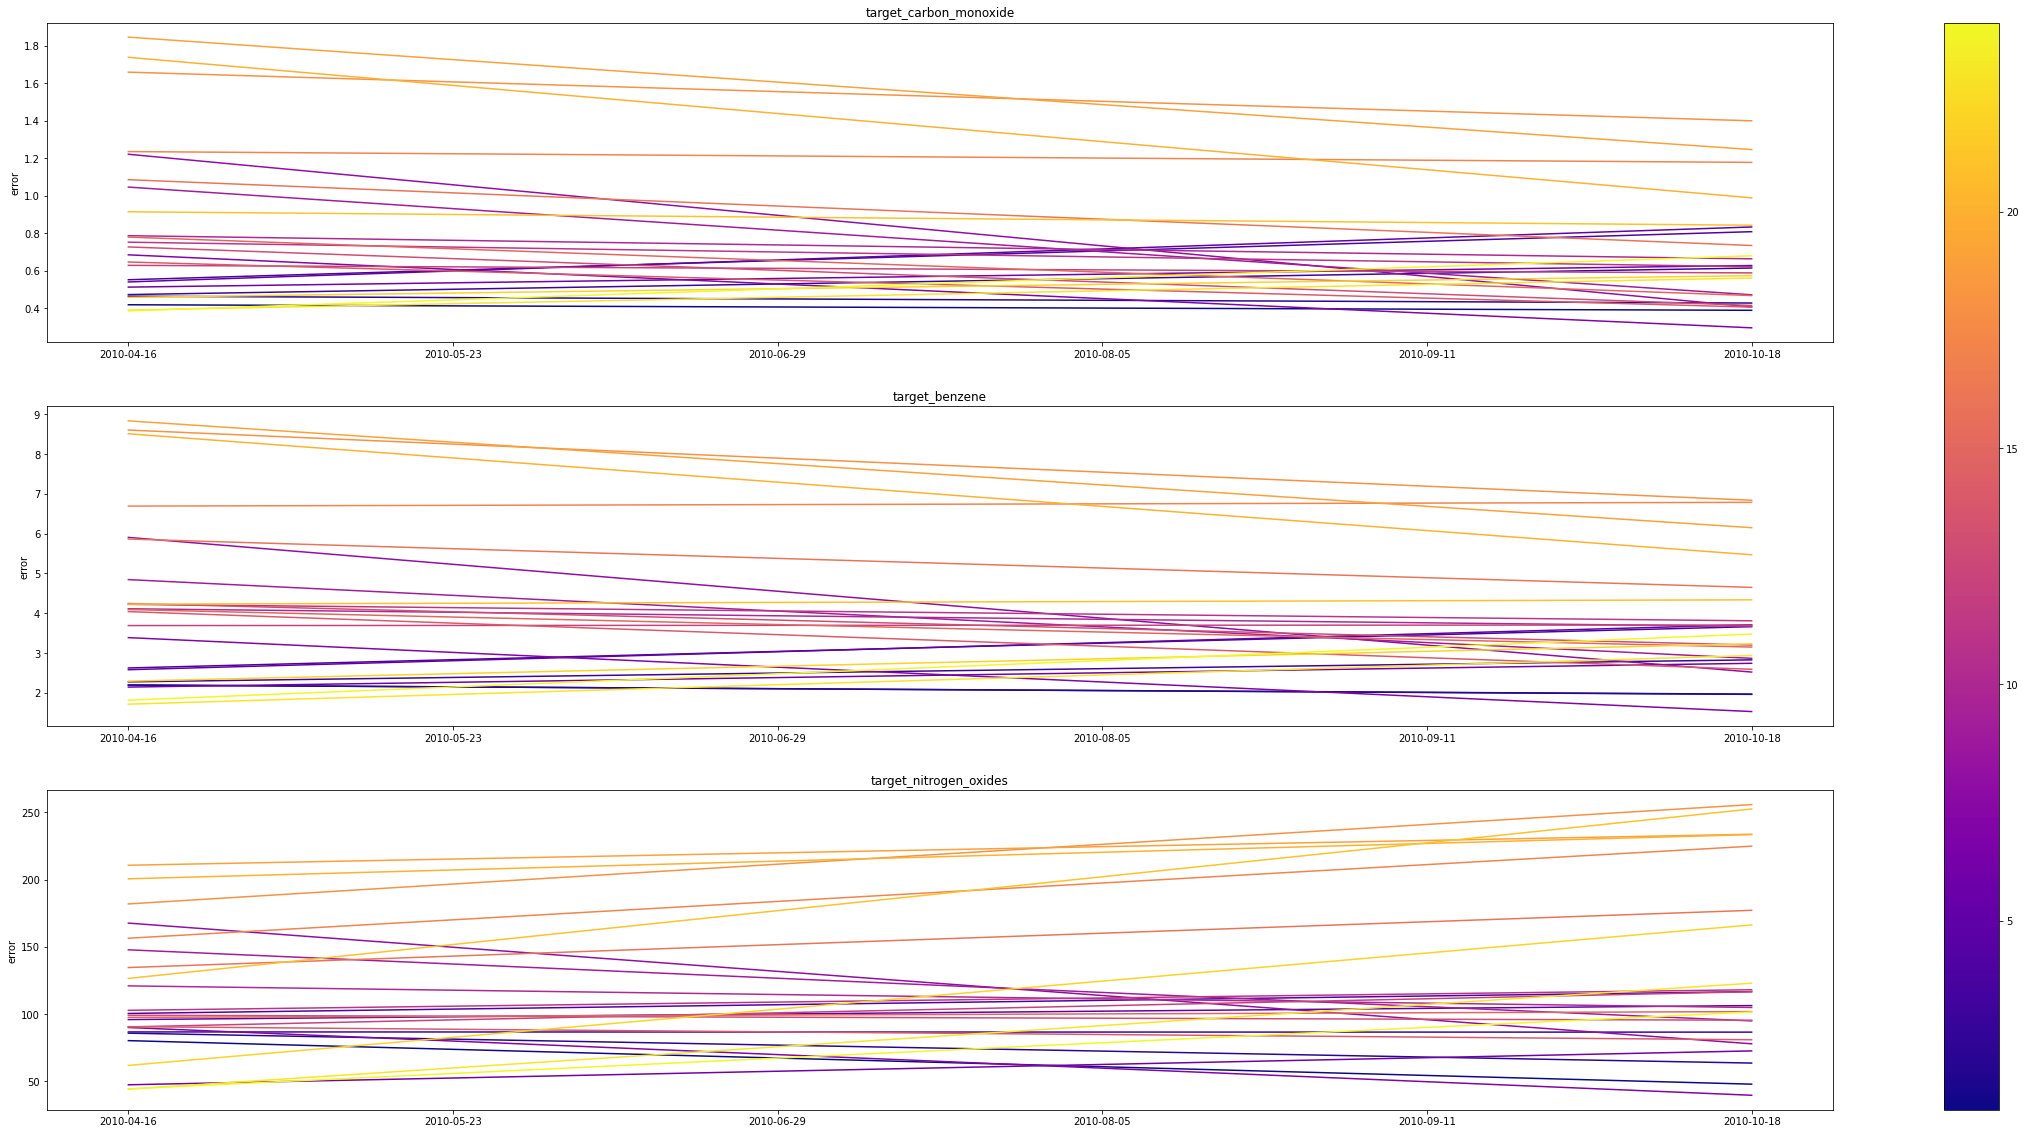

In [17]:
fig, axs = plt.subplots(3)
for ax in axs:
    ax.set_ylabel('error')
    
optimizer_forest = TimeSeriesWalkingForwardCV(RandomForestRegressor, test_size=24, n_splits=2, fig=fig, axs=axs, param_grid={'max_depth': [200], 'min_samples_leaf': [3]})
optimizer_forest.fit(features_scaled, np.array(Y), MAE)

for ax in axs:
    dates = list(data_cp.date_time.dt.date[::len(data_cp) // len(ax.get_xticklabels())].astype('string'))
    ax.set_xticklabels(dates)

In [237]:
def train_models(estimator, X_train, Y_train, horizons_n: int, params: dict):
    models = []
    for i in range(horizons_n):
        X_train = X_train[:-1]
        Y_train = Y_train.shift(-1).dropna()
        
        model = estimator(**params)
        model.fit(X_train, Y_train)
        
        models.append(model)
        
        print(f'{(i + 1) / (horizons_n) * 100:.2f}%', end='\r')
    
    return models

def predict(models, X_point):
    result = np.zeros(shape=(len(models), 3))
    
    for i, m in enumerate(models):
        result[i] = m.predict(np.array([X_point]))
    
    return result

In [238]:
h = 24*10

In [240]:
models = train_models(RandomForestRegressor, features_scaled[:-h], Y[:-h], h, params={'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 20, 'max_features': 'log2'})

In [241]:
result = predict(models, features_scaled[-h])

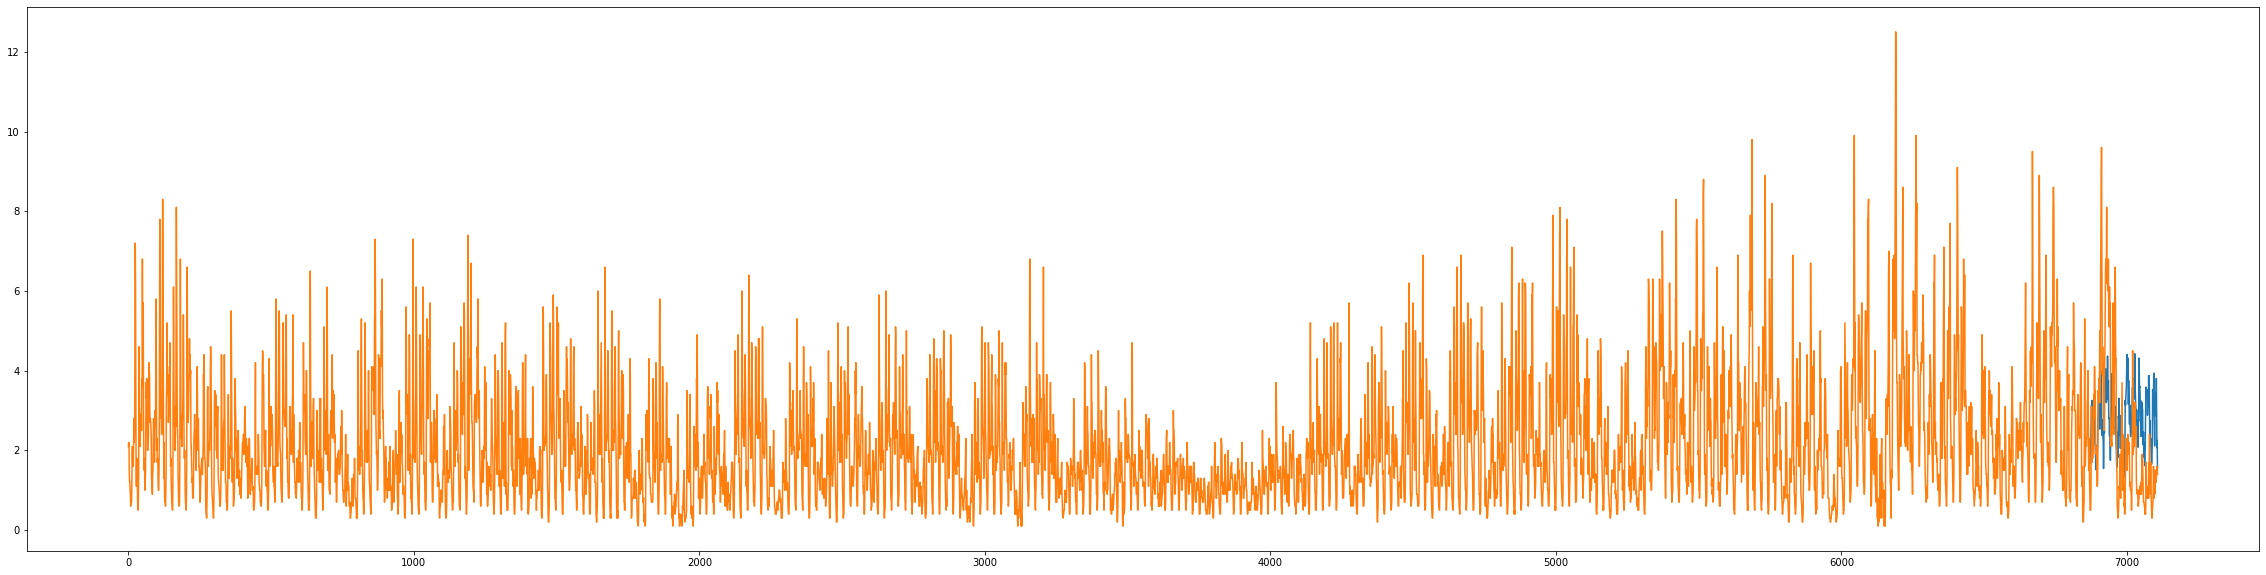

In [242]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 0])
plt.plot(list(range(len(Y))), Y['target_carbon_monoxide'])

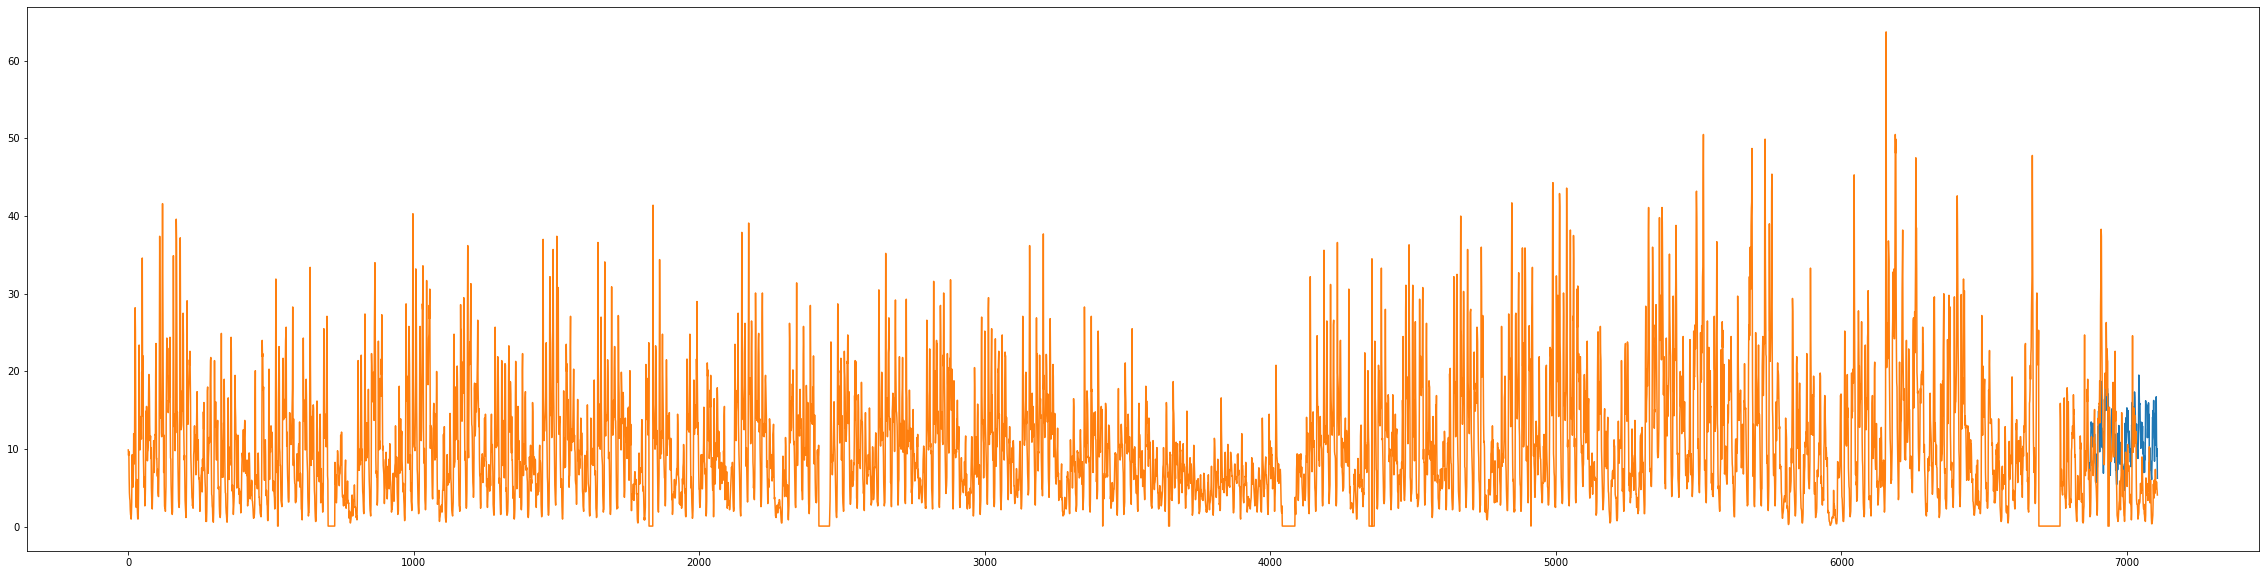

In [243]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 1])
plt.plot(list(range(len(Y))), Y['target_benzene'])

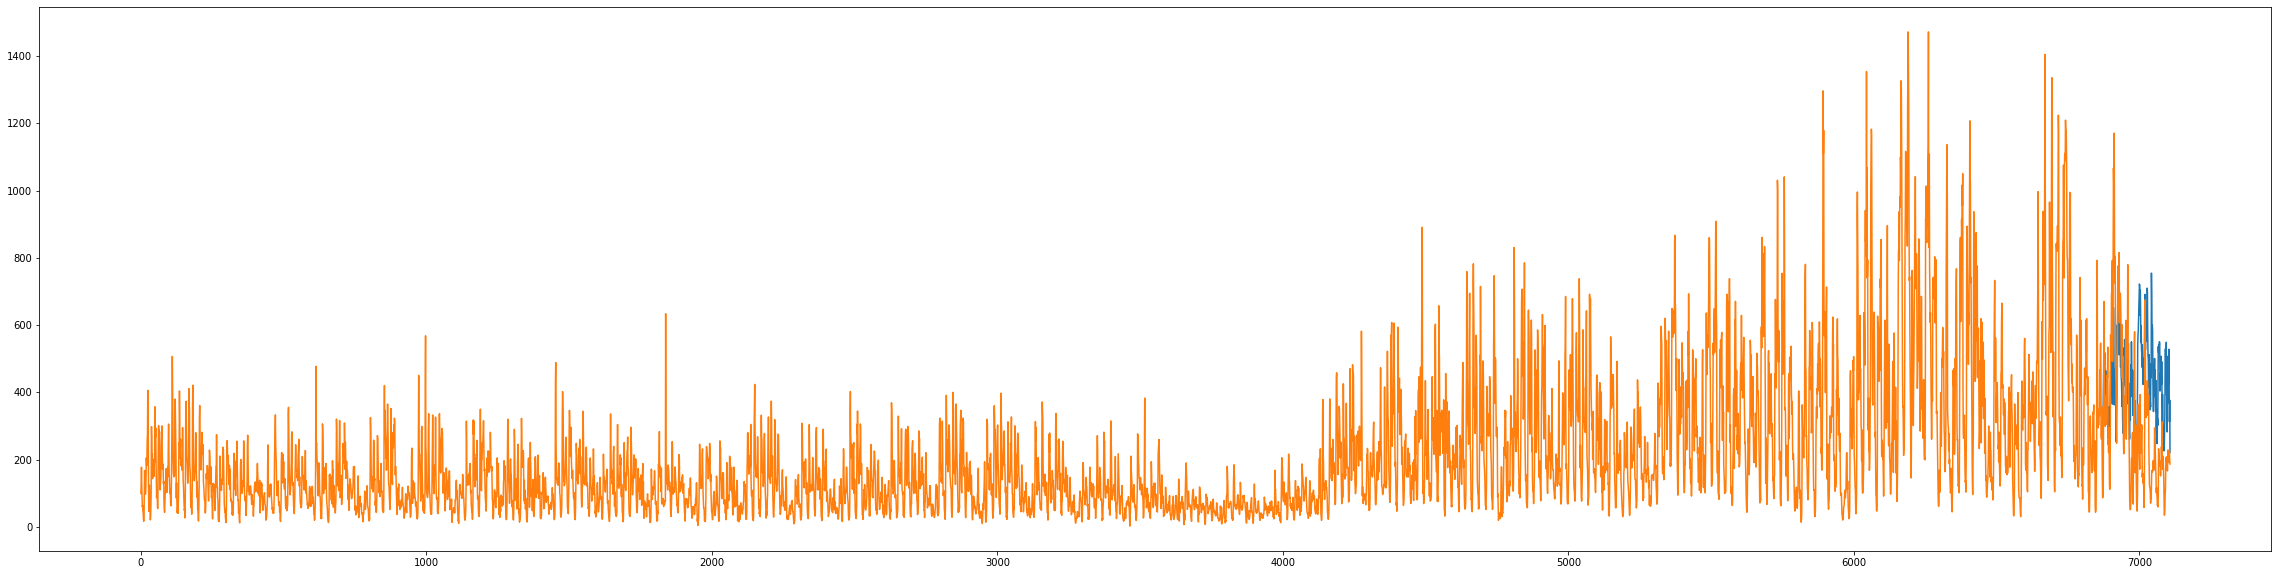

In [244]:
plt.rcParams["figure.figsize"] = (40, 10)
plt.plot(list(range(len(Y)))[-h:], result[:, 2])
plt.plot(list(range(len(Y))), Y['target_nitrogen_oxides'])

In [248]:
models[-1].feature_importances_

array([0.0130947 , 0.00898203, 0.01399716, 0.02129027, 0.01617862,
       0.02074485, 0.00980225, 0.01914885, 0.01393393, 0.00549827,
       0.01019185, 0.01133378, 0.00863261, 0.00772439, 0.00649193,
       0.01093719, 0.04190686, 0.04074593, 0.06230608, 0.03821116,
       0.01692141, 0.01050163, 0.01189671, 0.01817815, 0.00932298,
       0.00892619, 0.01152854, 0.01493987, 0.01801399, 0.00961064,
       0.01345603, 0.02502062, 0.01546415, 0.02319959, 0.01243095,
       0.03341405, 0.01338142, 0.00888805, 0.01145878, 0.01407113,
       0.11628038, 0.07786301, 0.00953893, 0.06770335, 0.        ,
       0.02389385, 0.0229429 ])